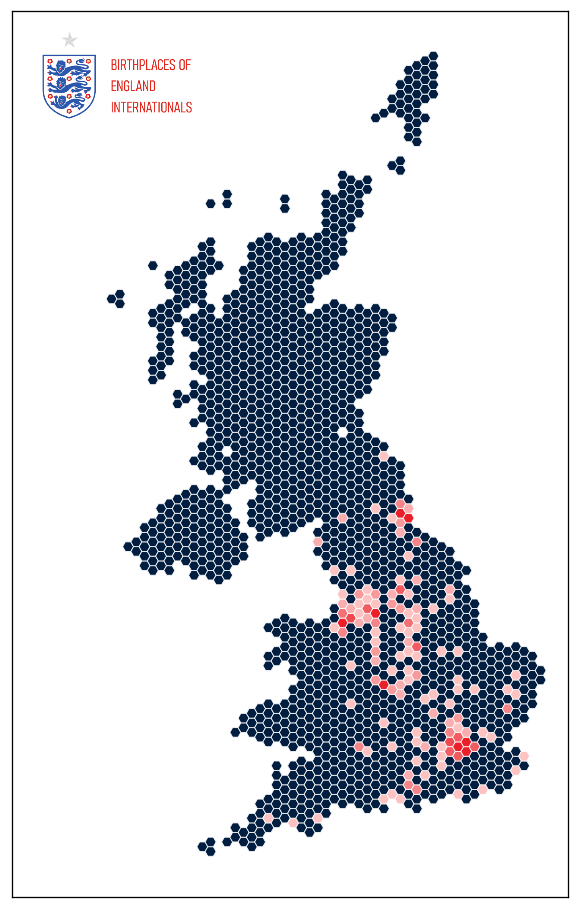

In [1]:
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg
from pathlib import Path

# === CONFIG ===
DATA_PATH = Path("C:/Users/higgsl/Python Projects/Datasets/england_footballers.csv")
SHAPE_PATH = Path("C:/Users/higgsl/Python Projects/Shapemaps/UK.geojson")
LOGO_PATH = Path("C:/Users/higgsl/Python Projects/Resources/england_internationals_header.png")
HEX_SIZE = 15000  # 15 km

# === 1. Load and Filter Data ===
try:
    df = pd.read_csv(DATA_PATH)
except FileNotFoundError:
    raise FileNotFoundError(f"CSV file not found at {DATA_PATH}")

df = df[df['Birth_Country'] == 'England']
df = df.groupby(['Latitude', 'Longitude']).size().reset_index(name='count')

# === 2. Convert to GeoDataFrame ===
points_gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['Longitude'], df['Latitude']),
    crs="EPSG:4326"
).to_crs(epsg=3857)

# === 3. Load UK Boundary ===
try:
    uk_boundary = gpd.read_file(SHAPE_PATH).to_crs(epsg=3857)
except FileNotFoundError:
    raise FileNotFoundError(f"GeoJSON file not found at {SHAPE_PATH}")

# === 4. Generate Hex Grid ===
def generate_hex_grid(minx, miny, maxx, maxy, hex_size):
    hexagons = []
    dx = 3/2 * hex_size
    dy = np.sqrt(3) * hex_size
    angles = [np.pi/3 * i for i in range(6)]

    x = minx
    row = 0
    while x < maxx + hex_size:
        y = miny
        while y < maxy + hex_size:
            cx = x
            cy = y + (row % 2) * dy / 2
            hexagon = Polygon([
                (cx + hex_size * np.cos(angle), cy + hex_size * np.sin(angle))
                for angle in angles
            ])
            hexagons.append(hexagon)
            y += dy
        x += dx
        row += 1
    hex_gdf = gpd.GeoDataFrame(geometry=hexagons, crs="EPSG:3857")
    return hex_gdf[hex_gdf.intersects(uk_boundary.union_all())]

minx, miny, maxx, maxy = uk_boundary.total_bounds
hex_gdf = generate_hex_grid(minx, miny, maxx, maxy, HEX_SIZE)

# === 5. Spatial Join ===
joined = gpd.sjoin(points_gdf, hex_gdf, how="left", predicate="within")
counts = joined.groupby(joined.index_right)['count'].sum()
hex_gdf['count'] = hex_gdf.index.map(counts).fillna(0)

# === 6. Color Mapping ===
cmap = LinearSegmentedColormap.from_list("custom_red", ["#FFD7D5", "#EA1F29"], N=10)

def get_color(value):
    if value == 0:
        return "#011E41"
    elif value >= 10:
        return "#EA1F29"
    else:
        return cmap(value / 10)

hex_gdf['color'] = hex_gdf['count'].apply(get_color)

# === 7. Plotting ===
fig, ax = plt.subplots(figsize=(8, 8), dpi=115)

hex_gdf.plot(
    ax=ax,
    color=hex_gdf['color'],
    edgecolor="white",
    linewidth=0.5
)

# === Expand axes limits to create space for logo ===
x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()
ax.set_xlim(x_min - (x_max - x_min) * 0.15, x_max)

# === Add Logo inside axes ===
try:
    logo_img = mpimg.imread(LOGO_PATH)
    imagebox = OffsetImage(logo_img, zoom=0.27)
    ab = AnnotationBbox(imagebox, (0.04, 0.98), xycoords='axes fraction', frameon=False, box_alignment=(0, 1))
    ax.add_artist(ab)
except FileNotFoundError:
    print(f"Logo image not found at {LOGO_PATH}")

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_aspect('equal')

plt.tight_layout()
plt.show()